In [102]:
%matplotlib inline

# General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# Keras
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils

Load the Crime data.

In [103]:
crime_adata = []
crime_alabels = []
with open("../train.csv", "rb") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    first_row = True
    for row in reader:
        data = [y for x, y in enumerate(row) if x != 1]
        name = [y for x, y in enumerate(row) if x == 1]
        
        if first_row:
            first_row = False
            feature_names = data
            print feature_names
        else:
            crime_adata.append(data)
            
            crime_alabels.append(name)

print crimea_data[:1]

['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']


NameError: name 'crimea_data' is not defined

Divide the Crime data into Train data, test data, mini train data, and dev sets

In [ ]:
# Divide the Crime training set into train data, test data, dev data
train_data, train_labels = crimea_adata[:500000], crime_alabels[:500000]
crime_test, crime_test_labels = crime_adata[500000:], crime_alabels[500000:]
num_test = len(crime_test)
print num_test
dev_data, dev_labels = crime_test[:num_test/2], crime_test_labels[:num_test/2]
test_data, test_labels = crime_test[num_test/2:], crime_test_labels[num_test/2:]
mini_train_data, mini_train_labels = crime_adata[200000:300000], crime_alabels[200000:300000]

print "Size of train data: ", len(train_data)
print "Size of dev data: ", len(dev_data)
print "Size of test data: ", len(test_data)

In [ ]:
data_df = pd.read_csv("../train.csv")
data_df_orig = data_df.copy()
data_df = data_df[data_df.Y != 90]
crime_data = np.array(data_df[['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']].values)
crime_labels = np.array(data_df[['Category']].values.ravel())
print crime_data[:1]

In [14]:
test_data_df = pd.read_csv("../test.csv")
test_data = np.array(test_data_df.values)
print test_data[:1]
test_data_df.columns.values

[[0L '2015-05-10 23:59:00' 'Sunday' 'BAYVIEW' '2000 Block of THOMAS AV'
  -122.39958770418998 37.7350510103906]]


array(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype=object)

In [6]:
# Creating the clusters for X, Y Coordinates
data_xy = np.array(data_df_orig[['X', 'Y']].values)
km = KMeans(n_clusters=100)
X_fit = km.fit(data_xy)
y = km.labels_
clusters = X_fit.labels_

In [7]:
test_xy = np.array(test_data_df[['X', 'Y']].values)
test_clusters = km.predict(test_xy)

The next section has all UTIL functions

In [8]:
clusters.shape
print clusters[:20]
test_clusters.shape
print test_clusters[:20]

[33 33 42 89 20 31 22 15 56 81 81 28 27 88  4 73 27 55 73 27]
[ 4 30 13 64 64 60 55 44 83 97 21 69 69 18 42 75 37 31 24 13]


In [15]:
from datetime import datetime
def convert_date(date_val):
    date_list = []
    date, time = date_val.split()
    date_list.append(int(date.split('-')[0]))
    date_list.append(int(date.split('-')[1]))
    date_list.append(int(date.split('-')[2]))
    time_in_min = int(time.split(':')[0]) * 60.0 + int(time.split(':')[1])
    date_list.append(time_in_min)
    date_list.append(int(time.split(':')[0]))
    time_hour = int(time.split(':')[0])
    if time_hour < 6:
        time_of_day = 'Twilight'
    elif time_hour < 12:
        time_of_day = 'Morning'
    elif time_hour < 18:
        time_of_day = 'Afternoon'
    else:
        time_of_day = 'Night'
    date_list.append(time_of_day)
    return date_list

print train_data[0][0]
print convert_date(train_data[0][0])

def find_mean_std(train_data, index):
    data = []
    for row in train_data:
        data.append(float(row[index]))
    
    data_arr = np.array(data, dtype=np.float32)
    print np.mean(data_arr)
    data_dict = {}
    data_dict['mean'] = np.mean(data_arr)
    data_dict['std'] = np.std(data_arr)
    return data_dict

2015-05-13 23:53:00
[2015, 5, 13, 1433.0, 23, 'Night']


In [16]:
date_arr = convert_date(train_data[0][0])
year, month, day, time_in_min, hour, time_of_day = date_arr

cyear = [(year < 2006) * 1, (year < 2008) * 1, (year < 2010) * 1, (year < 2012)*1, (year < 2015)*1, (year == 2015)*1]
print cyear

[0, 0, 0, 0, 0, 1]


Initialized Arrays

In [17]:
districts = ['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']
week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daytime = ['Twilight', 'Morning', 'Afternoon', 'Night']
year_range = ['2003-2006', '2006-2009', '2009-2012', 'After 2015']
crime_year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
crime_month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
crime_day = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29 ,30 ,31]
crime_hour = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Feature Engineering - Section I:

1) Crime Date - Normalization

2) Longitude & Latitude - Normalization

In [18]:
''' Crime Date - Normalization '''

year_data = []
mon_data = []
day_data = []
time_data = []
time_of_day_data = []
for row in crime_data:
    date_arr = convert_date(row[0])
    year_data.append(float(date_arr[0]))
    mon_data.append(float(date_arr[1]))
    day_data.append(float(date_arr[2]))
    time_data.append(float(date_arr[3]))
    time_of_day_data.append(date_arr[5])
                     

year_arr = np.array(year_data, dtype=np.float32)
mon_arr = np.array(mon_data, dtype=np.float32)
day_arr = np.array(day_data, dtype=np.float32)
time_arr = np.array(time_data, dtype=np.float32)
time_of_day_arr = np.array(time_of_day_data)

date_dict = {}
date_dict['mean_year'] = np.mean(year_arr)
date_dict['std_year'] = np.std(year_arr)                               
date_dict['mean_mon'] = np.mean(mon_arr)
date_dict['std_mon'] = np.std(mon_arr)
date_dict['mean_day'] = np.mean(day_arr)
date_dict['std_day'] = np.std(day_arr)
date_dict['mean_time'] = np.mean(time_arr)
date_dict['std_time'] = np.std(time_arr)


''' Longitude & Latitude - Normalization '''
long_dict = find_mean_std(train_data, 6)
lat_dict = find_mean_std(train_data, 7)

-122.423
37.7675


Preparing the Data

In [19]:

def get_formatted_data(train_data):
    format_data = []
    count = 0
    
    for i in range(len(train_data)):
        count += 1
        data = []
        row = train_data[i]
        
        ''' Data Preparation - Crime date '''
        
        #date_list = convert_date(row[0])
        # [2015, 5, 13, 1433.0, 23, 'Night']
        
        date_arr = convert_date(row[0])
        year, month, day, time_in_min, hour, time_of_day = date_arr
        
        norm_year = [1 if year == y else 0 for y in crime_year]
        data.extend(norm_year)
        
        norm_month = [1 if month == m else 0 for m in crime_month]
        data.extend(norm_month)
        
        norm_day = [1 if day == d else 0 for d in crime_day]
        data.extend(norm_day)
        
        norm_hour = [1 if hour == h else 0 for h in crime_hour]
        data.extend(norm_hour)
        
        # Time of the day preparation
        day_time = [1 if time_of_day == td else 0 for td in daytime]
        data.extend(day_time)
        
        
        ''' Data Preparation - Day of the Week '''
        wk_day = row[2]
        
        crime_week_day = [1 if wk_day == d else 0 for d in week_day] 
        data.extend(crime_week_day) # Normalized
        
        ''' Data Preparation - District '''
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts] # Normalized
        data.extend(pddistrict)
        
        ''' Data Preparation - Longitude & Latitude '''
        longitude = float(row[6])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std'] # Normalized
        latitude = float(row[7])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std'] # Normalized
        
        data.append(long_norm)
        data.append(lat_norm)
        
        cluster_label = clusters[i]
        data.append(cluster_label)
        
        ''' Data Preparation - Address '''
        
        address = row[5].lower()
        addr = [1 if 'block' in address else 0] # Requires major improvement
        data.extend(addr)
        
        # Explore external map source
        
        ''' Quantify the data '''
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    
crimeX = np.array(get_formatted_data(crime_data), dtype=np.float32)
print crimeX[:1]

[[  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    1.           0.           0.           0.           0.           1.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           1.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.           1.           0.           0.           0.      

In [20]:
print crimeX.shape

(877982L, 105L)


In [21]:
print "CrimeX Data shape: ", crimeX.shape
print "CrimeX Label shape: ", np.array(crime_labels).shape

CrimeX Data shape:  (877982L, 105L)
CrimeX Label shape:  (877982L,)


Building the Logistic Regression model on the entire Crime Training Data

In [22]:
params = {'C':[0.001, 0.01, 0.1, 0.2, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), params)
clf.fit(crimeX[:10000], crime_labels[:10000])
print clf.best_params_

{'C': 0.01}


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


In [23]:
lr = LogisticRegression(C=0.01)
lr.fit(crimeX, crime_labels)
print "Completed training with best C"

Completed training with best C


In [24]:
print 'hello'

hello


In [25]:
def get_formatted_test_data(test_data):
    format_data = []
    count = 0
    
    for i in range(len(test_data)):
        count += 1
        data = []
        
        row = test_data[i]
        
        ''' Data Preparation - Date '''
        date_arr = convert_date(row[1])
        year, month, day, time_in_min, hour, time_of_day = date_arr
        
        norm_year = [1 if year == y else 0 for y in crime_year]
        data.extend(norm_year)
        
        norm_month = [1 if month == m else 0 for m in crime_month]
        data.extend(norm_month)
        
        norm_day = [1 if day == d else 0 for d in crime_day]
        data.extend(norm_day)
        
        norm_hour = [1 if hour == h else 0 for h in crime_hour]
        data.extend(norm_hour)
        
        # Time of the day preparation
        day_time = [1 if time_of_day == td else 0 for td in daytime]
        data.extend(day_time)
        
        ''' Data Preparation - Day of the Week '''
        wk_day = row[2]
        
        crime_week_day = [1 if wk_day == d else 0 for d in week_day] 
        data.extend(crime_week_day) # Normalized
        
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts]
        data.extend(pddistrict)
        
        longitude = float(row[5])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std']
        latitude = float(row[6])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std']
        data.append(long_norm)
        data.append(lat_norm)
        
        test_cluster_label = test_clusters[i]
        data.append(test_cluster_label)
        
        if 'block' in row[4].lower():
            address = 1
        else:
            address = 0
        data.append(address)
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    

testX = np.array(get_formatted_test_data(test_data), dtype=np.float32)

        

In [26]:
print testX.shape

(884262L, 105L)


In [28]:
print probs.shape
print probs[:1]

(884262L, 39L)
[[ 0.0081226   0.13772509  0.00088868  0.00290412  0.03885434  0.00221439
   0.00380181  0.02013473  0.00632898  0.00099729  0.00131804  0.00189373
   0.00184039  0.00684142  0.00162343  0.00663832  0.14582495  0.00251005
   0.00046194  0.05445176  0.0835123   0.11219629  0.00144325  0.0002684
   0.00363221  0.03229263  0.00371116  0.03346342  0.00812909  0.00173907
   0.00522259  0.00147863  0.03644636  0.00064517  0.00632584  0.08039471
   0.08459471  0.03469086  0.02443723]]


In [59]:
print probs.shape
print probs[:1]

(884262L, 39L)
[[ 0.00598014  0.14235451  0.00039644  0.00095056  0.04091489  0.00200755
   0.00284076  0.01751568  0.0054245   0.00065421  0.00042781  0.00088631
   0.00179967  0.00680445  0.00042315  0.00505384  0.15562875  0.00179362
   0.00036821  0.05546664  0.08141095  0.11349672  0.00025786  0.00034429
   0.00303172  0.03292385  0.00276192  0.0313208   0.00717204  0.00044138
   0.00499776  0.0007008   0.03670595  0.00025392  0.00626717  0.08456407
   0.08833596  0.03474202  0.02257913]]


In [27]:
probs = lr.predict_proba(testX)

In [29]:
import gzip
with gzip.open('submission-matrix-3.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(probs):
        out.writerow([i] + list(prob))
print "Job completed"     

Job completed


In [28]:
gclf = GradientBoostingClassifier()
gclf.fit(crimeX, crime_labels)
print "Gradient Boosting Completed"

Gradient Boosting Completed


In [29]:
print "hello"

hello


In [31]:
gclf_probs = gclf.predict_proba(testX)
import gzip
with gzip.open('submission-matrix-gclf.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(gclf_probs):
        out.writerow([i] + list(prob))
print "Job completed"   

Job completed


In [32]:
print gclf_probs.shape
print gclf_probs[:1]

(884262L, 39L)
[[  3.02440836e-03   1.43862674e-01   2.03561777e-04   1.08661515e-03
    4.46352994e-02   1.79431247e-03   4.26209288e-03   2.22077394e-02
    4.31961594e-03   8.31534882e-04   2.49473397e-04   1.01547540e-03
    3.65270688e-03   8.62011288e-03   1.90901827e-04   4.25244762e-03
    1.29711833e-01   1.30613090e-03   3.64729688e-04   6.75900961e-02
    7.56290451e-02   1.03543899e-01   1.68236500e-05   5.60963927e-04
    1.56161420e-03   3.96501576e-02   4.48375028e-03   2.18597194e-02
    5.38789645e-03   2.49638507e-04   4.96575344e-03   4.87584338e-04
    4.72745625e-02   3.67647530e-06   6.41916468e-03   9.32536637e-02
    9.39834953e-02   3.89940423e-02   1.84927866e-02]]


In [10]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(crimeX, crime_labels)
print "Random Forest Training Completed"


Random Forest Training Completed


In [12]:
mini_testX, mini_test_labels = testX[:10000], test_labels[:10000]
f1_score = metrics.f1_score(clf.predict(mini_testX), mini_test_labels)
print f1_score

0.882141746499


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [16]:
clf_probs = clf.predict_proba(testX)
print clf_probs.shape
print clf_probs[:1]

(884262L, 39L)
[[ 0.          0.18        0.          0.          0.01333333  0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.48        0.          0.          0.03        0.07
   0.02        0.          0.          0.          0.02        0.          0.
   0.          0.          0.          0.          0.04        0.          0.
   0.04        0.08        0.02666667  0.        ]]


In [18]:
import gzip
with gzip.open('submission-matrix.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(clf_probs):
        out.writerow([i] + list(prob))
print "Job completed" 

Job completed


In [70]:
data_xy = np.array(data_df_orig[['X', 'Y']].values)

In [71]:
km = KMeans(n_clusters=20)
X_fit = km.fit(data_xy)
y = km.labels_
clusters = X_fit.labels_

In [142]:
print y.shape
print clusters.shape
clusters[:5]

(878049L,)
(878049L,)


array([13, 13, 27, 27, 52])

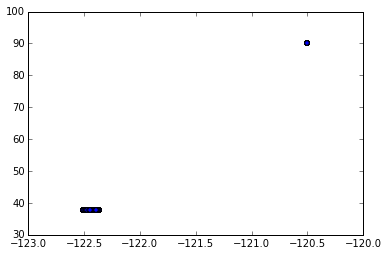

In [143]:
plt.scatter(data_xy[:,0], data_xy[:,1])

In [30]:
mini_testX, mini_test_labels = crimeX[800000:], crime_labels[800000:]
mini_devX, mini_dev_labels = crimeX[700000:800000], crime_labels[700000:800000]
mini_trainX, mini_train_labels = crimeX[:200000], crime_labels[:200000]
bnbb = BernoulliNB()
bnbb.fit(mini_trainX, mini_train_labels)
bnbb_probs = bnbb.predict_proba(mini_testX)
bnbb_accuracy = bnbb.score(mini_devX, mini_dev_labels)
# bnbb_log_loss = log_loss(mini_test_labels, bnbb_probs)
f1_score = metrics.f1_score(bnbb.predict(mini_testX), mini_test_labels)


print "BernoulliNB Results"
print "--------------------"
print "Accuracy: ", bnbb_accuracy
print "F1 Score: ", f1_score
#print "Log Loss: ", bnbb_log_loss


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BernoulliNB Results
--------------------
Accuracy:  0.08413
F1 Score:  0.0797225803152


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [31]:
lr = LogisticRegression(C=0.01)
lr.fit(mini_trainX, mini_train_labels)
lr_probs = lr.predict_proba(mini_testX)
lr_accuracy = lr.score(mini_devX, mini_dev_labels)
#lr_log_loss = log_loss(mini_test_labels, lr.predict_proba(mini_testX))
f1_score = metrics.f1_score(lr.predict(mini_testX), mini_test_labels)

print "Logistic Regression Results"
print "--------------------"
print "Accuracy: ", lr_accuracy
#print "Log Loss: ", lr_log_loss
print "F1 Score: ", f1_score

Logistic Regression Results
--------------------
Accuracy:  0.18898
F1 Score:  0.272224895686


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [32]:
rfclf = RandomForestClassifier(n_estimators=50)
rfclf.fit(mini_trainX, mini_train_labels)
rfclf_probs = rfclf.predict_proba(mini_testX)
rfclf_accuracy = rfclf.score(mini_devX, mini_dev_labels)
#lr_log_loss = log_loss(mini_test_labels, lr.predict_proba(mini_testX))
f1_score = metrics.f1_score(rfclf.predict(mini_testX), mini_test_labels)

print "Random Forest Regression Results"
print "--------------------"
print "Accuracy: ", rfclf_accuracy
#print "Log Loss: ", lr_log_loss
print "F1 Score: ", f1_score

Random Forest Regression Results
--------------------
Accuracy:  0.19042
F1 Score:  0.261775567148


C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [69]:
label_fields = {'Category': lambda x: labels.index(x.replace(',', ''))}

def get_fields(data, fields):
  extracted = []
  for row in data:
    extract = []
    for field, f in sorted(fields.items()):
      info = f(row[field])
      if type(info) == list:
        extract.extend(info)
      else:
        extract.append(info)
    extracted.append(np.array(extract, dtype=np.float32))
  return extracted


In [91]:
labels = 'ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS'.split(',')
label_fields = {'Category': lambda x: labels.index(x.replace(',', ''))}
crime_year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
crime_month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
crime_day = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29 ,30 ,31]
crime_hour = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

def dating(x):
    data = []
    date, time = x.split(' ')
    y, m, d = map(int, date.split('-'))
    time = time.split(':')[:2]
    time1 = time
    time = int(time[0]) * 60 + int(time[1])
    year = [1 if y == yr else 0 for yr in crime_year]
    data.extend(year)
    month = [1 if m == mon else 0 for mon in crime_month]
    data.extend(month)
    day = [1 if d == dy else 0 for dy in crime_day]
    data.extend(day)
    h = int(time1[0])
    hour = [1 if h == hr else 0 for hr in crime_hour]
    data.extend(hour)
    return data

def norm_long(x):
    return (abs(x) - abs(long_dict['mean']))/long_dict['std']

def norm_lat(x):
    return (abs(x) - abs(lat_dict['mean']))/lat_dict['std']

data_fields = {
    'X': lambda x: float(x),
    'Y': lambda x: float(y),
    'DayOfWeek': lambda x:[1 if x == wd else 0 for wd in week_day],
    'Address': lambda x: [1 if 'block' in x.lower() else 0],
    'PdDistrict': lambda x: [1 if x == d else 0 for d in districts],
    'Dates': dating,  # Parse 2015-05-13 23:53:00
}

def get_data(fn):
  data = []
  with open(fn) as f:
    reader = csv.DictReader(f)
    data = [row for row in reader]
  return data

def get_fields(data, fields):
  extracted = []
  for row in data:
    extract = []
    for field, f in sorted(fields.items()):
      info = f(row[field])
      if type(info) == list:
        extract.extend(info)
      else:
        extract.append(info)
    extracted.append(np.array(extract, dtype=np.float32))
  return extracted

def preprocess_data(X, scaler=None):
  if not scaler:
    scaler = StandardScaler()
    scaler.fit(X)
  X = scaler.transform(X)
  return X, scaler

def shuffle(X, y, seed=1337):
  np.random.seed(seed)
  shuffle = np.arange(len(y))
  np.random.shuffle(shuffle)
  X = X[shuffle]
  y = y[shuffle]
  return X, y


raw_train = get_data('../train.csv')
X = np.array(get_fields(raw_train, data_fields), dtype=np.float32)
y = np.array(get_fields(raw_train, label_fields))
X, y = shuffle(X, y)
X, scaler = preprocess_data(X)
del raw_train
Y = np_utils.to_categorical(y)
print "Training data preprocessed"

Training data preprocessed


In [92]:
raw_test = get_data('../test.csv')
print('Creating testing data...')
X_test = np.array(get_fields(raw_test, data_fields), dtype=np.float32)
del raw_test
X_test, _ = preprocess_data(X_test, scaler)


Creating testing data...


In [99]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

def get_model(input_dim, output_dim, wbit, dp, layers):
    keras = Sequential()
    keras.add(Dense(input_dim, wbit, init='glorot_uniform'))
    keras.add(PReLU((wbit,)))
    keras.add(Dropout(dp))

    for i in range(layers):
        keras.add(Dense(wbit, wbit, init='glorot_uniform'))
        keras.add(PReLU((wbit,)))
        keras.add(BatchNormalization((wbit,)))
        keras.add(Dropout(dp))

    keras.add(Dense(wbit, output_dim, init='glorot_uniform'))
    keras.add(Activation('softmax'))
    keras.compile(loss='categorical_crossentropy', optimizer='adam')
    return keras

input_dim = X.shape[1]
output_dim = 39
wbit = 64
EPOCHS = 1
RUN_FOLDS = False
BATCHES = 128
nb_folds = 4
dp = 0.5
layers = 3
kfolds = KFold(len(crime_labels), nb_folds)
keras = get_model(input_dim, output_dim, wbit, dp, layers)

In [94]:
keras.fit(X, Y, nb_epoch=1, batch_size=BATCHES, verbose=0)


In [96]:
keras_probs = keras.predict_proba(X_test, verbose=0)
print keras_probs[:1]

[[  3.48426832e-03   1.16913358e-01   9.31749807e-04   7.18774146e-04
    6.29154016e-02   6.94968199e-03   3.52990018e-03   4.30306703e-02
    5.76666126e-03   2.31244903e-03   6.48691587e-04   1.13350282e-03
    1.73865042e-02   1.98705418e-02   4.62154143e-04   4.85318963e-03
    1.05479662e-01   2.92981061e-03   1.51546359e-03   5.71302423e-02
    8.23094002e-02   1.23750257e-01   1.24792768e-04   6.28301369e-03
    7.41351862e-03   2.54724525e-02   4.69753348e-03   1.85440104e-02
    8.01852512e-03   4.87338186e-04   5.68227027e-03   1.02860750e-03
    4.56800496e-02   7.14054225e-05   1.07903542e-02   6.73824650e-02
    8.06356896e-02   3.87565456e-02   1.49090925e-02]]


In [101]:
print keras_probs[:1]

[[  3.48426832e-03   1.16913358e-01   9.31749807e-04   7.18774146e-04
    6.29154016e-02   6.94968199e-03   3.52990018e-03   4.30306703e-02
    5.76666126e-03   2.31244903e-03   6.48691587e-04   1.13350282e-03
    1.73865042e-02   1.98705418e-02   4.62154143e-04   4.85318963e-03
    1.05479662e-01   2.92981061e-03   1.51546359e-03   5.71302423e-02
    8.23094002e-02   1.23750257e-01   1.24792768e-04   6.28301369e-03
    7.41351862e-03   2.54724525e-02   4.69753348e-03   1.85440104e-02
    8.01852512e-03   4.87338186e-04   5.68227027e-03   1.02860750e-03
    4.56800496e-02   7.14054225e-05   1.07903542e-02   6.73824650e-02
    8.06356896e-02   3.87565456e-02   1.49090925e-02]]


In [97]:
import gzip
with gzip.open('submission-matrix-keras-4.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(keras_probs):
        out.writerow([i] + list(prob))
print "Job completed" 

Job completed


In [75]:
print y[:5]


[[  7.]
 [ 37.]
 [ 20.]
 [ 16.]
 [ 20.]]


In [76]:
mini_testX, mini_test_labels = X[800000:], y[800000:]
mini_devX, mini_dev_labels = X[700000:800000], y[700000:800000]
mini_trainX, mini_train_labels = X[:200000], y[:200000]

lr = LogisticRegression(C=0.01)
lr.fit(mini_trainX, mini_train_labels)
lr_probs = lr.predict_proba(mini_testX)
lr_accuracy = lr.score(mini_devX, mini_dev_labels)
#lr_log_loss = log_loss(mini_test_labels, lr.predict_proba(mini_testX))
f1_score = metrics.f1_score(lr.predict(mini_testX), mini_test_labels)

print "Logistic Regression Results"
print "--------------------"
print "Accuracy: ", lr_accuracy
#print "Log Loss: ", lr_log_loss
print "F1 Score: ", f1_score

C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pgundugola\Downloads\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Logistic Regression Results
--------------------
Accuracy:  0.22843
F1 Score:  0.317925008596


In [100]:
def get_pre_data(fn):
  data = []
  with open(fn) as f:
    reader = csv.DictReader(f)
    data = [row for row in reader]
  return data
raw_train = get_pre_data('../train.csv')
print raw_train[:1]

[{'Category': 'WARRANTS', 'DayOfWeek': 'Wednesday', 'Dates': '2015-05-13 23:53:00', 'Descript': 'WARRANT ARREST', 'PdDistrict': 'NORTHERN', 'Address': 'OAK ST / LAGUNA ST', 'Y': '37.7745985956747', 'X': '-122.425891675136', 'Resolution': 'ARREST, BOOKED'}]


In [ ]:
def get_prep_data(fn):
  data = []
  with open(fn) as f:
    reader = csv.DictReader(f)
    full_data = []
    for row in reader:
        data = {}
        data['Category'] = row['Category']
        data['DayOfWeek'] = row['DayOfWeek']
        data['Dates'] = row['Dates']
        data['Descript'] = row['Descript']
        data['PdDistrict'] = row['PdDistrict']
        data['Address'] = row['Address']
        data['Longitude'] 
  return data
raw_train = get_prep_data('../train.csv')
print raw_train[:1]

In [ ]:
# Creating the clusters for X, Y Coordinates
data_xy = np.array(data_df_orig[['X', 'Y']].values)
km = KMeans(n_clusters=100)
X_fit = km.fit(data_xy)
y = km.labels_
clusters = X_fit.labels_